In [1]:
# Importing relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from matplotlib.patches import Rectangle

from config_reader import read_config

/usr/local/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Reading paths
paths = read_config()
# Path to where we will save our processed files
INDIR = paths['PROCESSED_FOLDER_LOCAL']
# Path to where we will save our processed files
OUTDIR = paths['PLOTS_FOLDER_LOCAL']

In [80]:
# Reading relevant files

# Reading authors in our new filtered sample
df_main = pd.read_csv(INDIR+"RW_authors_w_confounders_filteredSample_postNHB_BedoorsCorrections_Augmented.csv")

# Only extracting those with single retraction
df_main = df_main[df_main['nRetracted']==1]

df_main['Attrition'] = df_main['AttritedClass']
df_main['YearsActiveNew'] = df_main['YearsActive']

df_main.columns.tolist()

/var/folders/bf/_6xjm2bn2_n17hfhskyq1pmw0000gp/T/ipykernel_80226/276290178.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv(INDIR+"RW_authors_w_confounders_filteredSample_postNHB_BedoorsCorrections_Augmented.csv")


['MAGAID',
 'MAGAuthorName',
 'Record ID',
 'MAGPID',
 'RetractionYear',
 'nRetracted',
 'dateobject',
 'JID',
 'CSID',
 'JournalName',
 'ConferenceSeriesName',
 'ReasonPropagatedMajorityOfMajority',
 'NumAuthorsInRetractedPaper',
 'GenderizeGender',
 'GenderizeConfidence',
 'MAGAuthorOrder',
 'FirstPubMAGPID',
 'MAGFirstPubYear',
 'AcademicAgeAtRetraction',
 'MAGCumPapersYearAtRetraction',
 'MAGCumPapersAtRetraction',
 'MAGCumCitationsYearAtRetraction',
 'MAGCumCitationsAtRetraction',
 'MAGCumCollaboratorsYearAtRetraction',
 'MAGCumCollaboratorsAtRetraction',
 'MAGRetractionYearAffID',
 'MAGRetractionYearAffRank',
 'MAGRetractionYearAffYear',
 'MAGrootFID',
 'MAGrootFIDMaxPercent',
 'YearsActive',
 'OriginalPaperDate',
 'OriginalPaperYear',
 'AttritedClass',
 'AttritedClassRobust',
 'MAGJCName',
 'MAGJournalType',
 'SJRScoreRetractedPaperYear',
 'SJRQuartileRetractedPaperYear',
 'DemiDecade',
 'MAGAuthorOrderCategorical',
 'MAGFieldName',
 'Field_art',
 'Field_biology',
 'Field_busine

In [81]:
# Only extracting relevant columns
relevant_columns = ['Record ID', 'MAGPID', 'MAGAID', 'MAGFieldName', 
                   'GenderizeGender', 'AcademicAgeAtRetraction', 'MAGRetractionYearAffRank',
                   'ReasonPropagatedMajorityOfMajority', 'NumAuthorsInRetractedPaper', 
                   'MAGAuthorOrderCategorical', 'RetractionYear', 'DemiDecade',
                   'MAGJournalType', 'MAGCumPapersAtRetraction', 'MAGCumCitationsAtRetraction',
                   'MAGCumCollaboratorsAtRetraction', 'SJRQuartileRetractedPaperYear',
                   'SJRScoreRetractedPaperYear', 'Attrition', 'YearsActiveNew']

df_relevant = df_main[relevant_columns].drop_duplicates()

# 0 means non-attrited, 1 means attrited, -1 means attrited due to something else
df_relevant[['MAGAID','Attrition']].drop_duplicates()['Attrition'].value_counts()

Attrition
 0    10342
 1     2400
-1     1837
Name: count, dtype: int64

In [83]:
# Computing Years Active 
df_main['YearsActive'] = df_main['YearOfAttrition']-df_main['RetractionYear']

# When year of attrition == -1, we do not know the years active, so we won't plot them
df_main.loc[df_main['YearOfAttrition'] == -1, 'YearsActive'] = np.nan

df_main.head(1)

,MAGAID,MAGAuthorName,Record ID,MAGPID,RetractionYear,nRetracted,dateobject,JID,CSID,JournalName,...,AltmetricScorePreRetraction,AltmetricScorePostRetraction,MAGFirstAffID,FirstAffRank,FirstAffRankCorrected,YearOfAttrition,MAGFirstAffiliationRank,RetractorMajority,Attrition,YearsActiveNew
0,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,3.0,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0


In [84]:
# Let us add author order

# Define the function to apply to each row
def categorize_author(row):
    if row['MAGAuthorOrder'] == 1:
        if row['NumAuthorsInRetractedPaper'] == 1:
            return "first and last author"
        else:
            return "first author"
    elif row['MAGAuthorOrder'] > 1 and row['NumAuthorsInRetractedPaper'] == row['MAGAuthorOrder']:
        return "last author"
    else:
        return "middle author"

# Apply the function to ea\ch row
df_main['FirstorLastorMiddleAuthor'] = df_main.apply(categorize_author, axis=1)

In [85]:
df_relevant_w_lastactivity = df_main.copy()

In [86]:
# Some Pre-processing

# Processing fields so that we only plot those with >= 5 % population

# Classifying fields with < 5% as other stem and non-stem
other_stem_fields = ['materials science', 'computer science',
                'engineering', 'mathematics', 'psychology',
                'economics', 'environmental science', 'geography','sociology',
                'political science', 'geology']


non_stem_fields = ['philosophy','business',
                  'history','art']

df_relevant_w_lastactivity['MAGFieldName'] = df_relevant_w_lastactivity['MAGFieldName']\
                                                   .replace(dict.fromkeys(other_stem_fields, 'other STEM fields'))\
                                                    .replace(dict.fromkeys(non_stem_fields,'non-STEM fields'))


# Preprocessing affiliation ranks
df_relevant_w_lastactivity['MAGRetractionYearAffRank'] = df_relevant_w_lastactivity['MAGRetractionYearAffRankOrdinal']\
                                                .replace([rank for rank in range(101)], '1-100')\
                                                .replace([rank for rank in range(101,501)], 
                                                         '101-500')\
                                                .replace([rank for rank in range(501,1001)], 
                                                         '501-1000')\
                                                .replace(1500, '>1000')

# Preprocessing Journal Quartile
df_relevant_w_lastactivity['SJRQuartileRetractedPaperYear'] = df_relevant_w_lastactivity['SJRQuartileRetractedPaperYear']\
                                        .replace({1.0:'Q1',
                                                 2.0:'Q2',
                                                 3.0:'Q3',
                                                 4.0:'Q4'})\
                                        .fillna('NA')



df_attrited = df_relevant_w_lastactivity[df_relevant_w_lastactivity.YearsActive.ge(-1) &
                                        df_relevant_w_lastactivity.YearsActive.le(0)]

df_nonattrited = df_relevant_w_lastactivity[df_relevant_w_lastactivity.YearsActive.gt(0)]


df_relevant_w_lastactivity


,MAGAID,MAGAuthorName,Record ID,MAGPID,RetractionYear,nRetracted,dateobject,JID,CSID,JournalName,...,AltmetricScorePostRetraction,MAGFirstAffID,FirstAffRank,FirstAffRankCorrected,YearOfAttrition,MAGFirstAffiliationRank,RetractorMajority,Attrition,YearsActiveNew,FirstorLastorMiddleAuthor
0,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
1,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
2,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
3,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
4,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28857,1826158756,nabeel alsaffar,4885,2078164144,2013.0,1,2012-01-21,11732831.0,NaN,environmental monitoring and assessment,...,0.0,143601524.0,NaN,1500.0,2012.0,1001-,author,1,-1.0,middle author
28858,268272321,alex mishelevitz,16929,1970421558,2012.0,1,2012-10-01,112095004.0,NaN,journal of chemical technology & biotechnology,...,0.0,124227911.0,401.0,450.0,2012.0,401-500,NaN,1,0.0,middle author
28859,2768061868,munesh kumari,2071,2108644616,2014.0,1,2013-10-01,202381698.0,NaN,plos one,...,0.0,66760702.0,NaN,1500.0,-1.0,1001-,NaN,0,NaN,middle author
28860,2639980879,d k hazra,8363,1420593637,2014.0,1,2014-01-01,NaN,NaN,NaN,...,0.0,109963156.0,NaN,1500.0,2014.0,1001-,NaN,1,0.0,first author


In [87]:
df_attrited.MAGAID.nunique()

2400

In [88]:
df_nonattrited.MAGAID.nunique()

988

# Distribution of authors' last activity

## Stratification by age

In [89]:
# Code for creating the bar plot

def create_attrition_barplot(dfi, axesi, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position, 
                        dashline_yMax, ylimMax, set_xlabel=False,
                            ylabel='% of retracted \nauthors who left'):
    
    # Only extracting relevant dataframe
    print()
    # Computing the groups
    df_grouped_values_treatment = dfi[['MAGAID','YearsActive']]\
                .drop_duplicates()\
                .groupby('YearsActive')['MAGAID'].nunique().reset_index()
    
    # Computing number of authors in our set
    num_authors = dfi.MAGAID.nunique()
    print("old",num_authors)
    
    num_authors = dfi[~dfi.YearsActive.isna()]\
                            .MAGAID.nunique()
    
    print("new",num_authors)

    # Getting Percentage of retracted scientists
    df_grouped_values_treatment['Percentage of Retracted Scientists'] = \
        round(df_grouped_values_treatment['MAGAID']*100.0/num_authors,1)
    
    print(df_grouped_values_treatment['Percentage of Retracted Scientists'].sum())
    
    # Filtering to only include authors within certain years range
    df_grouped_values_treatment = df_grouped_values_treatment[\
                                df_grouped_values_treatment['YearsActive'].ge(-10) & 
                                df_grouped_values_treatment['YearsActive'].le(10)]
    
    # Imputing ticks that do not exist i.e. 0 within -10 and 10 range
    ######
    # Create a new dataframe with the full range of YearsActive from -10 to 10
    full_range = pd.DataFrame({'YearsActive': range(-10, 11)})
    # Merge the new range with the existing dataframe, ensuring all years are included
    df_grouped_values_treatment = full_range.merge(df_grouped_values_treatment, on='YearsActive', how='left')
    # Replace NaN values with -1 in all columns except 'YearsActive'
    df_grouped_values_treatment.fillna(0, inplace=True)
    ######
    
    df_grouped_values_treatment['YearsActive'] = df_grouped_values_treatment['YearsActive'].astype(int)

    # Setting colors for bars
    
    colors = [other_color if (x < -1) else (nonattrited_color if (x > 0) else attrited_color) \
                  for x in df_grouped_values_treatment.YearsActive.tolist()]


    barplot_treatment = sns.barplot(data=df_grouped_values_treatment, ax=axesi,
                            x='YearsActive', y="Percentage of Retracted Scientists", palette=colors,
                                   saturation=1)

    barplot_treatment.tick_params(labelsize=ticksize)

    for item in barplot_treatment.get_xticklabels():
        item.set_rotation(60)

    for patch in barplot_treatment.patches:
        
        value = patch.get_height()
        if(value >= 1):
            barplot_treatment.annotate(format(value, '.1f'), 
                           (patch.get_x() + patch.get_width() / 2., patch.get_height()+1), 
                           ha = 'center', va = 'center', fontsize=labelsize, weight='regular',
                           xytext = (0, 9), 
                           textcoords = 'offset points')
    
    if set_xlabel:
        barplot_treatment.set_xlabel('year of last publication since retraction (year 0)', 
                              fontsize=labelsize)
    else:
        barplot_treatment.set_xlabel('')

    barplot_treatment.set_ylabel(ylabel, fontsize=labelsize)
    
    barplot_treatment.axvline(dashline_position, ymax=dashline_yMax, color='black', lw=2, linestyle='--')
    
    barplot_treatment.set_ylim(0,ylimMax)
    
    sns.despine()

In [90]:
def label_subplots(axi, labeli, xi=-0.1, yi=1.03):
    
    # Labeling the figure so that they can be referred in the paper
    axi.text(xi, yi, labeli, transform=axi.transAxes, fontfamily='DejaVu Sans',
      fontsize=20, fontweight='extra bold')


old 4280
new 2896
99.89999999999999

old 3648
new 1302
100.1

old 6651
new 1027
101.0


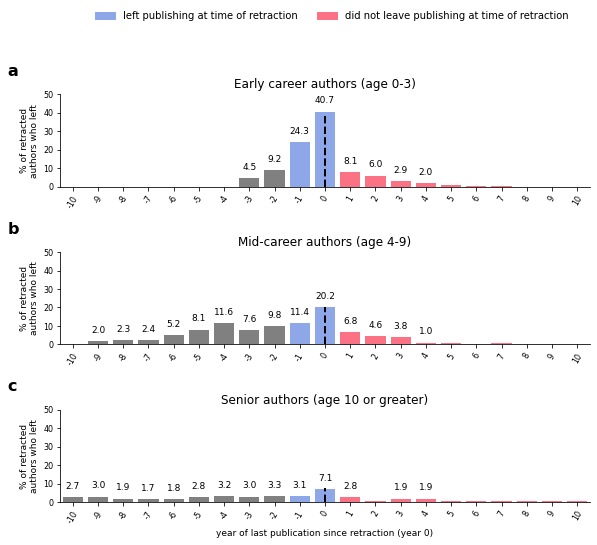

In [105]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

# Create grid specification for the subplots
gs = gridspec.GridSpec(3, 1)

# Create the figure and axes based on the grid specification
fig = plt.figure(figsize=(8.3, 6.9))

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])


df_relevant_w_lastactivity_young = df_relevant_w_lastactivity\
                                    [df_relevant_w_lastactivity.AcademicAgeAtRetraction.isin([0,1,2,3])]


df_relevant_w_lastactivity_mid = df_relevant_w_lastactivity\
                                    [df_relevant_w_lastactivity.AcademicAgeAtRetraction.isin([4,5,6,7,
                                                                                             8,9])]


df_relevant_w_lastactivity_senior = df_relevant_w_lastactivity\
                                    [df_relevant_w_lastactivity.AcademicAgeAtRetraction.ge(10)]



# FIRST PLOT 

dfi = df_relevant_w_lastactivity_young.copy()

attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'

#plt.rcParams["figure.figsize"] = (8.3,1.7)

#fig, axesi = plt.subplots()

ticksize = 8
labelsize = 9
dashline_position = 10
yMax = 50

create_attrition_barplot(dfi, ax1, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position, dashline_yMax = 0.80, 
                         ylimMax=yMax,
                        ylabel='% of retracted\nauthors who left')

# Create a custom legend with two squares
blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')

# fig.patches.append(rect)


# SECOND PLOT 
dfi = df_relevant_w_lastactivity_mid.copy()

attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'

ticksize = 8
labelsize = 9
dashline_position = 10


create_attrition_barplot(dfi, ax2, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position, dashline_yMax = 0.40, 
                        ylimMax=yMax,
                        ylabel='% of retracted\nauthors who left')

# Create a custom legend with two squares
blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')

# fig.patches.append(rect)

# THIRD PLOT
dfi = df_relevant_w_lastactivity_senior.copy()

attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'

ticksize = 8
labelsize = 9
dashline_position = 10
create_attrition_barplot(dfi, ax3, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position,
                        dashline_yMax = 0.15, ylimMax=yMax, set_xlabel=True,
                        ylabel='% of retracted\nauthors who left')

# Create a custom legend with two squares
legend_handles = [patches.Rectangle((0,0),1,1, color=attrited_color),
                  patches.Rectangle((0,0),1,1, color=nonattrited_color)]
legend_labels = ['left publishing at time of retraction', 'did not leave publishing at time of retraction']

fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', ncol=2,
          bbox_to_anchor=(0.55, 1.1), frameon=False)



rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')

# Annotating figures
# label_subplots(ax1, "a", xi=-0.1, yi=1.4)
# label_subplots(ax2, "b", xi=-0.1, yi=1.5)
ax1.text(-0.1, 1.2, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax2.text(-0.1, 1.2, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold')
ax3.text(-0.1, 1.2, 'c', transform=ax3.transAxes, fontsize=16, fontweight='bold')

ax1.set_title('Early career authors (age 0-3)')
ax2.set_title('Mid-career authors (age 4-9)')
ax3.set_title('Senior authors (age 10 or greater)')
# fig.patches.append(rect)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()

plt.savefig(OUTDIR+'/attrition_barplot_byAge_new.pdf', format='pdf')

In [99]:
df_relevant_w_lastactivity

,MAGAID,MAGAuthorName,Record ID,MAGPID,RetractionYear,nRetracted,dateobject,JID,CSID,JournalName,...,AltmetricScorePostRetraction,MAGFirstAffID,FirstAffRank,FirstAffRankCorrected,YearOfAttrition,MAGFirstAffiliationRank,RetractorMajority,Attrition,YearsActiveNew,FirstorLastorMiddleAuthor
0,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
1,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
2,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
3,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
4,2127983451,william r jacobs,2343,1790891469,1997.0,1,1994-07-01,133274750.0,NaN,journal of bacteriology,...,6.0,204465549.0,22.0,22.0,-1.0,22,NaN,0,-19.0,last author
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28857,1826158756,nabeel alsaffar,4885,2078164144,2013.0,1,2012-01-21,11732831.0,NaN,environmental monitoring and assessment,...,0.0,143601524.0,NaN,1500.0,2012.0,1001-,author,1,-1.0,middle author
28858,268272321,alex mishelevitz,16929,1970421558,2012.0,1,2012-10-01,112095004.0,NaN,journal of chemical technology & biotechnology,...,0.0,124227911.0,401.0,450.0,2012.0,401-500,NaN,1,0.0,middle author
28859,2768061868,munesh kumari,2071,2108644616,2014.0,1,2013-10-01,202381698.0,NaN,plos one,...,0.0,66760702.0,NaN,1500.0,-1.0,1001-,NaN,0,NaN,middle author
28860,2639980879,d k hazra,8363,1420593637,2014.0,1,2014-01-01,NaN,NaN,NaN,...,0.0,109963156.0,NaN,1500.0,2014.0,1001-,NaN,1,0.0,first author


In [93]:
df_relevant_w_lastactivity.columns

Index(['MAGAID', 'MAGAuthorName', 'Record ID', 'MAGPID', 'RetractionYear',
       'nRetracted', 'dateobject', 'JID', 'CSID', 'JournalName',
       ...
       'AltmetricScorePostRetraction', 'MAGFirstAffID', 'FirstAffRank',
       'FirstAffRankCorrected', 'YearOfAttrition', 'MAGFirstAffiliationRank',
       'RetractorMajority', 'Attrition', 'YearsActiveNew',
       'FirstorLastorMiddleAuthor'],
      dtype='object', length=139)

## Stratification by affiliation rank

In [117]:
dftemp = df_relevant_w_lastactivity[['MAGAID','MAGRetractionYearAffRank','YearsActive']].drop_duplicates()
dftemp[~dftemp['YearsActive'].isna() & dftemp['MAGRetractionYearAffRank'].eq('>1000')]['YearsActive']\
        .value_counts().sum()

2004


old 3143
new 878
99.2
4522

old 4522
new 1581
100.59999999999998

old 1988
new 762
100.19999999999997

old 4926
new 2004
98.4


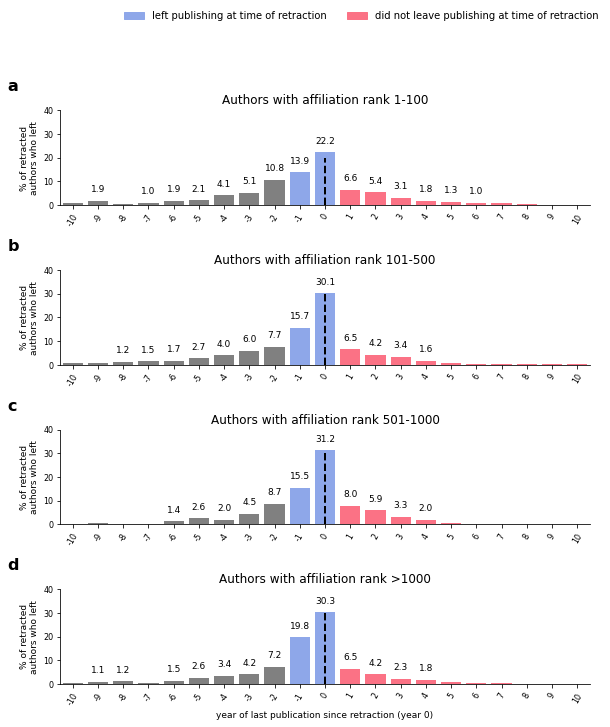

In [121]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

# Create grid specification for the subplots
gs = gridspec.GridSpec(4, 1)

# Create the figure and axes based on the grid specification
fig = plt.figure(figsize=(8.3, 9.2))

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

df_relevant_w_lastactivity_1to100aff = df_relevant_w_lastactivity\
                                    [df_relevant_w_lastactivity['MAGRetractionYearAffRank']=='1-100']


df_relevant_w_lastactivity_101to500aff = df_relevant_w_lastactivity\
                                    [df_relevant_w_lastactivity['MAGRetractionYearAffRank']=='101-500']


df_relevant_w_lastactivity_501to1000aff = df_relevant_w_lastactivity\
                                    [df_relevant_w_lastactivity['MAGRetractionYearAffRank']=='501-1000']


df_relevant_w_lastactivity_gt1000aff = df_relevant_w_lastactivity\
                                    [df_relevant_w_lastactivity['MAGRetractionYearAffRank']=='>1000']


# FIRST PLOT 

dfi = df_relevant_w_lastactivity_1to100aff.copy()


attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'

#plt.rcParams["figure.figsize"] = (8.3,1.7)

#fig, axesi = plt.subplots()

ticksize = 8
labelsize = 9
dashline_position = 10
yMax = 40

create_attrition_barplot(dfi, ax1, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position, dashline_yMax = 0.50, ylimMax=yMax,
                        ylabel='% of retracted\nauthors who left')

# Create a custom legend with two squares
blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')


# SECOND PLOT 
dfi = df_relevant_w_lastactivity_101to500aff.copy()

print(dfi.MAGAID.nunique())

attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'



create_attrition_barplot(dfi, ax2, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position, dashline_yMax = 0.75, 
                        ylimMax=yMax,
                        ylabel='% of retracted\nauthors who left')

# Create a custom legend with two squares
blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')


# THIRD PLOT
dfi = df_relevant_w_lastactivity_501to1000aff.copy()


attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'


create_attrition_barplot(dfi, ax3, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position,
                        dashline_yMax = 0.75, ylimMax=yMax,
                        ylabel='% of retracted\nauthors who left')

# Fourth plot
dfi = df_relevant_w_lastactivity_gt1000aff.copy()


attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'


create_attrition_barplot(dfi, ax4, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position,
                        dashline_yMax = 0.75, ylimMax=yMax, set_xlabel=True,
                        ylabel='% of retracted\nauthors who left')


legend_handles = [patches.Rectangle((0,0),1,1, color=attrited_color),
                  patches.Rectangle((0,0),1,1, color=nonattrited_color)]
legend_labels = ['left publishing at time of retraction', 'did not leave publishing at time of retraction']

fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', ncol=2,
          bbox_to_anchor=(0.60, 1.1), frameon=False)

# # Create a custom legend with two squares
# blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
# red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')

# Annotating figures

ax1.text(-0.1, 1.2, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax2.text(-0.1, 1.2, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold')
ax3.text(-0.1, 1.2, 'c', transform=ax3.transAxes, fontsize=16, fontweight='bold')
ax4.text(-0.1, 1.2, 'd', transform=ax4.transAxes, fontsize=16, fontweight='bold')

ax1.set_title('Authors with affiliation rank 1-100')
ax2.set_title('Authors with affiliation rank 101-500')
ax3.set_title('Authors with affiliation rank 501-1000')
ax4.set_title('Authors with affiliation rank >1000')

# fig.patches.append(rect)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()

plt.savefig(OUTDIR+'/attrition_barplot_byAffiliation_new.pdf', format='pdf')

## Stratification by reasons


old 3347
new 1219
100.2
4221

old 4221
new 1640
99.69999999999997

old 4132
new 1368
99.79999999999997


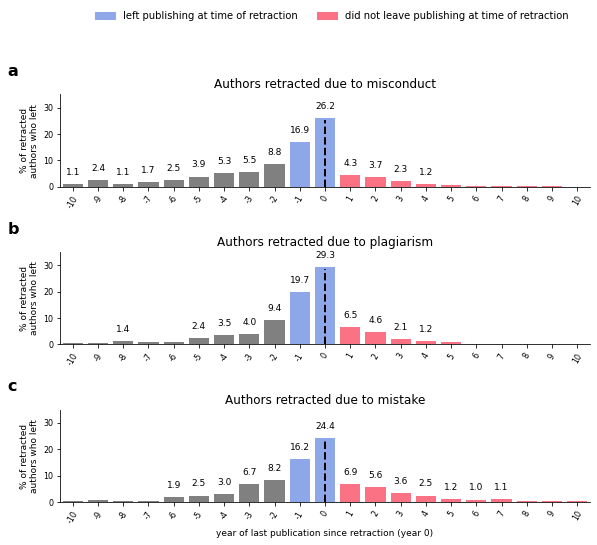

In [135]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

# Create grid specification for the subplots
gs = gridspec.GridSpec(3, 1)

# Create the figure and axes based on the grid specification
fig = plt.figure(figsize=(8.3, 6.9))

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

df_relevant_w_lastactivity_misconduct = df_relevant_w_lastactivity\
                            [df_relevant_w_lastactivity['ReasonPropagatedMajorityOfMajority']=='misconduct']


df_relevant_w_lastactivity_plagiarism = df_relevant_w_lastactivity\
                            [df_relevant_w_lastactivity['ReasonPropagatedMajorityOfMajority']=='plagiarism']


df_relevant_w_lastactivity_mistake = df_relevant_w_lastactivity\
                                    [df_relevant_w_lastactivity['ReasonPropagatedMajorityOfMajority']=='mistake']


# FIRST PLOT 

dfi = df_relevant_w_lastactivity_misconduct.copy()


attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'

#plt.rcParams["figure.figsize"] = (8.3,1.7)

#fig, axesi = plt.subplots()

ticksize = 8
labelsize = 9
dashline_position = 10
yMax = 35

create_attrition_barplot(dfi, ax1, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position, dashline_yMax = 0.72, ylimMax=yMax,
                        ylabel='% of retracted\nauthors who left')

# Create a custom legend with two squares
blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')


# SECOND PLOT 
dfi = df_relevant_w_lastactivity_plagiarism.copy()

print(dfi.MAGAID.nunique())

attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'



create_attrition_barplot(dfi, ax2, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position, dashline_yMax = 0.82, 
                        ylimMax=yMax,
                        ylabel='% of retracted\nauthors who left')

# Create a custom legend with two squares
blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')


# THIRD PLOT
dfi = df_relevant_w_lastactivity_mistake.copy()


attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'


create_attrition_barplot(dfi, ax3, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position,
                        dashline_yMax = 0.68, ylimMax=yMax, set_xlabel=True,
                        ylabel='% of retracted\nauthors who left')


legend_handles = [patches.Rectangle((0,0),1,1, color=attrited_color),
                  patches.Rectangle((0,0),1,1, color=nonattrited_color)]
legend_labels = ['left publishing at time of retraction', 'did not leave publishing at time of retraction']

fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', ncol=2,
          bbox_to_anchor=(0.55, 1.1), frameon=False)

# # Create a custom legend with two squares
# blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
# red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')

# Annotating figures

ax1.text(-0.1, 1.2, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax2.text(-0.1, 1.2, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold')
ax3.text(-0.1, 1.2, 'c', transform=ax3.transAxes, fontsize=16, fontweight='bold')

ax1.set_title('Authors retracted due to misconduct')
ax2.set_title('Authors retracted due to plagiarism')
ax3.set_title('Authors retracted due to mistake')

# fig.patches.append(rect)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()

plt.savefig(OUTDIR+'/attrition_barplot_byReason_new.pdf', format='pdf')

## Stratification by author order


old 2832
new 1255
100.6
8827

old 8827
new 3066
100.19999999999999

old 2920
new 904
99.4


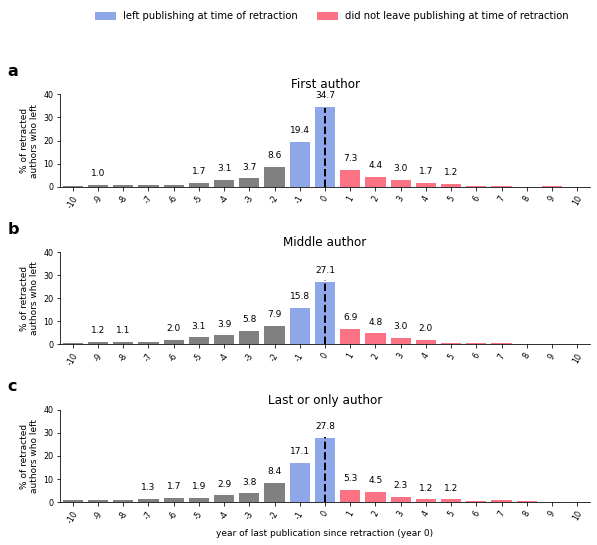

In [139]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

# Create grid specification for the subplots
gs = gridspec.GridSpec(3, 1)

# Create the figure and axes based on the grid specification
fig = plt.figure(figsize=(8.3, 6.9))

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

df_relevant_w_lastactivity_firstauthor = df_relevant_w_lastactivity\
                            [df_relevant_w_lastactivity['FirstorLastorMiddleAuthor']=='first author']


df_relevant_w_lastactivity_lastauthor = df_relevant_w_lastactivity\
                            [df_relevant_w_lastactivity['FirstorLastorMiddleAuthor'].\
                                 isin(['last author','first and last author'])]


df_relevant_w_lastactivity_middleauthor = df_relevant_w_lastactivity\
                            [df_relevant_w_lastactivity['FirstorLastorMiddleAuthor'].\
                                 eq('middle author')]


# FIRST PLOT 

dfi = df_relevant_w_lastactivity_firstauthor.copy()


attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'

#plt.rcParams["figure.figsize"] = (8.3,1.7)

#fig, axesi = plt.subplots()

ticksize = 8
labelsize = 9
dashline_position = 10
yMax = 40

create_attrition_barplot(dfi, ax1, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position, dashline_yMax = 0.85, ylimMax=yMax,
                        ylabel='% of retracted\nauthors who left')

# Create a custom legend with two squares
blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')


# SECOND PLOT 
dfi = df_relevant_w_lastactivity_middleauthor.copy()

print(dfi.MAGAID.nunique())

attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'

# ticksize = 8
# labelsize = 9
# dashline_position = 3

create_attrition_barplot(dfi, ax2, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position, dashline_yMax = 0.70, 
                        ylimMax=yMax,
                        ylabel='% of retracted\nauthors who left')

# Create a custom legend with two squares
blue_square = plt.Line2D([], [], color=attrited_color, marker='s', markersize=10, label='left publishing')
red_square = plt.Line2D([], [], color=nonattrited_color, marker='s', markersize=10, label='did not leave publishing')

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')


# THIRD PLOT
dfi = df_relevant_w_lastactivity_lastauthor.copy()


attrited_color = '#8EA7E9'#'#FFD93D'
nonattrited_color = "#fb7285"
other_color = 'gray'

# ticksize = 8
# labelsize = 9
# dashline_position = 3
create_attrition_barplot(dfi, ax3, ticksize, labelsize, attrited_color,
                        nonattrited_color, other_color, dashline_position,
                        dashline_yMax = 0.70, ylimMax=yMax, set_xlabel=True,
                        ylabel='% of retracted\nauthors who left')


legend_handles = [patches.Rectangle((0,0),1,1, color=attrited_color),
                  patches.Rectangle((0,0),1,1, color=nonattrited_color)]
legend_labels = ['left publishing at time of retraction', 'did not leave publishing at time of retraction']

fig.legend(handles=legend_handles, labels=legend_labels, loc='upper center', ncol=2,
          bbox_to_anchor=(0.55, 1.1), frameon=False)

rect = Rectangle((0, 0), 1, 1.1, transform=fig.transFigure, fill=False, edgecolor='black')

# Annotating figures

ax1.text(-0.1, 1.2, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold')
ax2.text(-0.1, 1.2, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold')
ax3.text(-0.1, 1.2, 'c', transform=ax3.transAxes, fontsize=16, fontweight='bold')

ax1.set_title('First author')
ax2.set_title('Middle author')
ax3.set_title('Last or only author')

# fig.patches.append(rect)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.tight_layout()

plt.savefig(OUTDIR+'/attrition_barplot_byAuthorOrder_new.pdf', format='pdf')